# Machine Learning  #

## Problem Formulation ##

* Remove unneed columns, for example:
    * duplicated
    * categorical features that were turned into one-hot.
    * features that identify specific rows, like ID number.
    * make sure your target is properly encoded also.
* Split training sample into train, validation, and test sub-samples.


In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_curve, auc


In [70]:
# ----- load data -----
try: 
    train = pd.read_csv("proteinas_train.csv")
    test = pd.read_csv("proteinas_test.csv")
    
    print("***** Data loaded successfully *****")
    print(f"Train shape: {train.shape}\nTest shape: {test.shape}\n")

    # Vertify critical columns exist
    required_cols = ['Massa_Molecular', 'Ponto_Isoelétrico', 'Classe']
    assert all(col in train.columns for col in required_cols), "Missing required columns"
except Exception as e:
    print(f"Loading Failed: {str(e)}")

***** Data loaded successfully *****
Train shape: (16000, 10)
Test shape: (4000, 10)



In [71]:
# ----- Initial data inspection -----
print("----- Initial Data Inspection (Train)-----")
print(train.head())

print("----- Initial Data Inspection (Test)-----")
print(test.head())

----- Initial Data Inspection (Train)-----
    ID_Proteína                                          Sequência  \
0  TRAIN_P00001  GNMRFVLHDEETHWGTLRTTLNCVPSDIYTISGEDSLFWGMAHPFC...   
1  TRAIN_P00002  LFKMQCSFYLLYLAKEAASYQVSMNMLCYEWYNYVYQVTVILRLSR...   
2  TRAIN_P00003  PAHLWPYWRFYVWIVFYGYHNPNYHFGMKEVKERPDCKNCTVAVLF...   
3  TRAIN_P00004  GEAFSRPHCFACAATKKGFPWARMCCTTSMAMDGVQSKMHKSKHRF...   
4  TRAIN_P00005  HYVFQGLMLHCGGYMITACGFGVIFPEQMTREGLIMHTARAHHFLI...   

   Massa_Molecular  Ponto_Isoelétrico  Hidrofobicidade  Carga_Total  \
0       20362.9468           4.866123         0.149425           -3   
1        9328.7909           6.298636         0.217105            0   
2       17616.3852           8.458977         0.192568            8   
3       35244.2968           8.448340         0.160473           21   
4       34557.9931           7.696306         0.140411           18   

   Proporção_Polar  Proporção_Apolar  Comprimento_Sequência      Classe  
0         0.241379          0.40804

In [72]:
# ----- Define Features -----
numerical_features = ['Massa_Molecular', 'Ponto_Isoelétrico', 'Hidrofobicidade', 'Carga_Total', 
                'Proporção_Polar', 'Proporção_Apolar', 'Comprimento_Sequência']

categorical_features = ['ID_Proteína', 'Sequência']
target_feature = 'Classe'

In [73]:
# Feature engineering amino acidc compostion features
def calc_aa_features(sequence):
    """ Calculate various amino acids from sequnces """
    if pd.isna(sequence):
        return pd.Series([np.nan]*6)
        
    aa_counts = pd.Series(list(sequence)).value_counts(normalize=True)
    return pd.Series({
        'Hydrophobic_AA': aa_counts.reindex(['A','V','L','I','P','F','W','M'], fill_value=0).sum(),
        'Charged_AA': aa_counts.reindex(['R','H','K','D','E'], fill_value=0).sum(),
        'Polar_AA': aa_counts.reindex(['N','C','Q','S','T','Y'], fill_value=0).sum(),
        'Small_AA': aa_counts.reindex(['A','G','S','T'], fill_value=0).sum(),
        'Aromatic_AA': aa_counts.reindex(['F','W','Y','H'], fill_value=0).sum(),
        'Proline_Content': aa_counts.get('P', 0)}) 

In [74]:
train_aa_features = train['Sequência'].apply(calc_aa_features)
test_aa_features = test['Sequência'].apply(calc_aa_features)

# adding to existing DataFrame
train = pd.concat([train, train_aa_features], axis=1)
test = pd.concat([test, test_aa_features], axis=1)

numerical_features.extend(['Hydrophobic_AA', 'Charged_AA', 'Polar_AA', 
                   'Small_AA', 'Aromatic_AA', 'Proline_Content'])

In [75]:
from sklearn.impute import SimpleImputer
# ------ Data Cleaning ------
# Handles missing values- using median for imputation.
imputer =  SimpleImputer(strategy='median')
train[numerical_features] = imputer.fit_transform(train[numerical_features])
test[numerical_features] = imputer.transform(test[numerical_features])

In [76]:
#----- Validate sequence lengths match Comprimento_Sequência -----
train['Seq_length_check'] = train['Sequência'].str.len() == train['Comprimento_Sequência']
test['Seq_length_check'] = test['Sequência'].str.len() == test['Comprimento_Sequência']

print(f"Mismatched sequence lengths: Train={(train['Seq_length_check'] == False).sum()},Test={(test['Seq_length_check']== False).sum()}") # # Check for sequence length inconsistencies 

Mismatched sequence lengths: Train=0,Test=0


In [77]:
# Removing temporary column
train.drop('Seq_length_check', axis=1, inplace = True)
test.drop('Seq_length_check', axis=1, inplace = True)

In [78]:
# Dropping unnecessary columns
train = train.drop(['ID_Proteína', 'Sequência'], axis=1) # drop ID from original sequence 
test = test.drop(['ID_Proteína', 'Sequência'], axis=1) # drop ID from original sequence 

In [79]:
# Feature Scaling
scaler = StandardScaler()
train[numerical_features] = scaler.fit_transform(train[numerical_features])
test[numerical_features] = scaler.transform(test[numerical_features])

In [80]:
# Display Processed Data
print("\n--- Processed Train Data (First 5 rows) ---")
print(train.head())

print("\n--- Processed Test Data (First 5 rows) ---")
print(test.head())


--- Processed Train Data (First 5 rows) ---
   Massa_Molecular  Ponto_Isoelétrico  Hidrofobicidade  Carga_Total  \
0        -0.039785          -1.663031        -0.020281    -1.556178   
1        -1.311270          -0.673868         2.442265    -1.158177   
2        -0.356276           0.817866         1.549457    -0.096839   
3         1.675018           0.810521         0.381691     1.627835   
4         1.595934           0.291235        -0.348269     1.229834   

   Proporção_Polar  Proporção_Apolar  Comprimento_Sequência      Classe  \
0         1.213878          0.192362              -0.000462  Estrutural   
1         0.303072          2.683715              -1.344437  Estrutural   
2        -1.723074          1.571107              -0.357027  Estrutural   
3        -0.326818          0.209849               1.672650  Estrutural   
4         0.052986         -0.469135               1.617794   Receptora   

   Hydrophobic_AA  Charged_AA  Polar_AA  Small_AA  Aromatic_AA  \
0        0.

In [81]:
# Split Data Training
x = train.drop(target_feature, axis=1)
y = train[target_feature]

# first split train into 60% and temp 40%
X_train, X_temp, y_train, y_temp = train_test_split(
    x, y, test_size=0.4, random_state=42, stratify=y
)

# then split 40% temp into 20% validation and 20% test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Train set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Train set size: 9600
Validation set size: 3200
Test set size: 3200


## Train ML Algorithm ##

In [82]:
# Model initialization
clf = HistGradientBoostingClassifier(random_state=42)

In [83]:
# feature columns
print("Feature columns:", X_train.columns.tolist())

# Check for non-numeric columns
non_numeric = X_train.select_dtypes(exclude=['number']).columns
print("Non-numeric columns:", non_numeric.tolist())

# ID columns shouldn't be features:
X_train = X_train.select_dtypes(include=['number'])
X_test = X_test.select_dtypes(include=['number'])

Feature columns: ['Massa_Molecular', 'Ponto_Isoelétrico', 'Hidrofobicidade', 'Carga_Total', 'Proporção_Polar', 'Proporção_Apolar', 'Comprimento_Sequência', 'Hydrophobic_AA', 'Charged_AA', 'Polar_AA', 'Small_AA', 'Aromatic_AA', 'Proline_Content']
Non-numeric columns: []


In [84]:
# Model Training
clf.fit(X_train, y_train)

HistGradientBoostingClassifier(random_state=42)

## Evaluate Performance on Validation Sample ##

In [85]:
# prediction on validation set
X_val = X_val[X_train.columns]
y_pred_val = clf.predict(X_val)

In [86]:
# compute metrics
print("\n--- Validation Set Performance ---")
print(classification_report(y_val, y_pred_val))
print("Accuracy:", accuracy_score(y_val, y_pred_val))


--- Validation Set Performance ---
              precision    recall  f1-score   support

      Enzima       0.20      0.21      0.21       647
  Estrutural       0.20      0.20      0.20       646
      Outras       0.20      0.21      0.21       637
   Receptora       0.18      0.18      0.18       625
  Transporte       0.20      0.19      0.20       645

    accuracy                           0.20      3200
   macro avg       0.20      0.20      0.20      3200
weighted avg       0.20      0.20      0.20      3200

Accuracy: 0.198125


In [87]:
# Confusion Matrix
cm = cm = confusion_matrix(y_val, y_pred_val)
print("\nConfusion Matrix (Validation Set):")
print(cm)


Confusion Matrix (Validation Set):
[[137 138 114 129 129]
 [127 129 149 119 122]
 [127 119 132 131 128]
 [155 132 119 114 105]
 [133 125 133 132 122]]


In [88]:
# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()

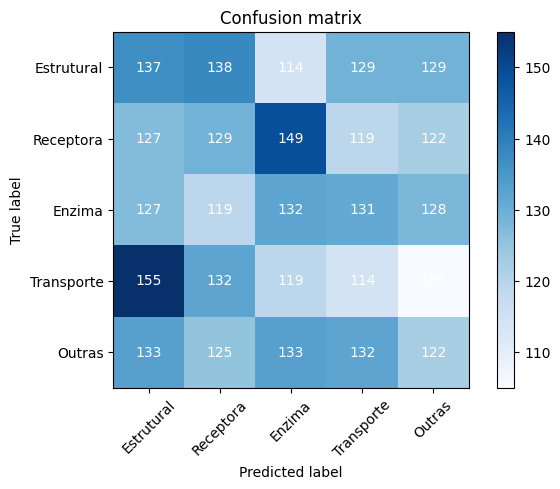

In [89]:
plot_confusion_matrix(cm, classes=train['Classe'].unique(),
                      title='Confusion matrix')


## Apply ML to the challenge test set ##

* Once trained, apply the ML algorithm the the test dataset and generate the submission file.


In [90]:
y_pred_test = clf.predict(X_test)

In [91]:
print("\t\t--- Test Set Predictions ---")
print(y_pred_test)

		--- Test Set Predictions ---
['Enzima' 'Receptora' 'Outras' ... 'Transporte' 'Outras' 'Estrutural']


In [92]:
# Evaluate the performance for test set
print("\t\t--- Test Set Performance ---\n")
print(classification_report(y_test, y_pred_test))
print("Test set accuracy: ", accuracy_score(y_test, y_pred_test))

		--- Test Set Performance ---

              precision    recall  f1-score   support

      Enzima       0.21      0.22      0.21       647
  Estrutural       0.21      0.22      0.22       647
      Outras       0.20      0.20      0.20       636
   Receptora       0.20      0.20      0.20       625
  Transporte       0.19      0.17      0.18       645

    accuracy                           0.20      3200
   macro avg       0.20      0.20      0.20      3200
weighted avg       0.20      0.20      0.20      3200

Test set accuracy:  0.2040625


In [93]:
# Confusion Matrix performance for Test set
cm_test = confusion_matrix(y_test, y_pred_test)
print("Confusion Matrix (Test Set): ")
print(cm_test)

Confusion Matrix (Test Set): 
[[141 142 135 130  99]
 [122 145 126 115 139]
 [137 119 130 136 114]
 [120 148 112 127 118]
 [146 129 147 113 110]]


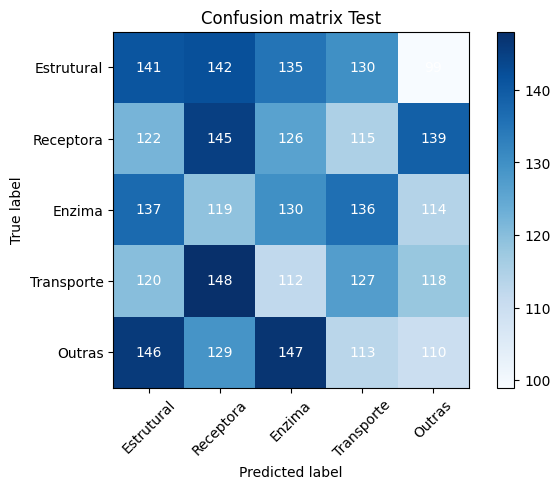

In [94]:
# plot confusion matrix for test set
plot_confusion_matrix(cm_test, classes=train['Classe'].unique(),
                      title='Confusion matrix Test') 